# Machine learning from scratch: multiple and polynomial regression

## Introduction

In this notebook we investigate how to fit linear and polynomial models to multivariable data sets. Let us start by importing the usual scientific libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Multiple linear regression

In a previous notebook, we studied how to fit a straight line to a data set. The main idea was to consider a cost function $J(\theta)$ and minimize it with respect to the parameters $\theta$. More precisely, we stacked the data points in a vector $X$, augmented this vector to a matrix $M$ adding a column of $1$'s, and considered the mean square error

$$
J = \dfrac{1}{2m}(M\theta-y)^T(M\theta-y).
$$

An advantage of this formulation is that it immediately generalizes to higher dimensions, as the same expression means the same when each data point has multple variables. Thus, instead of having a vector $X$ of length $m$, we will now have a matrix of shape $m\times n$, where $n$ is the number of variables of our inputs. We augment again this matrix adding a column of $1$'s, resulting in a matrix $M$ of shape $m\times(n+1)$. The gradient of the cost function with respect to the parameters $\theta$ has the exact same for as in the single variable case:

$$
\nabla J = \dfrac{1}{m}M^T(M\theta- y).
$$

We can hence use the exact same gradient descent algorithm to find the minimum as we did in the single variable case:

In [2]:
def cost_function(X, y, theta):
    m = X.shape[0]
    M = np.hstack((np.ones(m).reshape(-1,1),X))
    return float( (1/(2*m))*(M.dot(theta) - y).T.dot(M.dot(theta) - y) )

def gradient(X,y,theta):
    z = y.reshape(-1,1)
    m = X.shape[0]
    M = np.hstack((np.ones(m).reshape(-1,1),X))
    return (1/m)*M.T.dot(M.dot(theta)-z).reshape(-1,1)

def linear_regression(X, y, num_steps, learn_rate):
    theta = (2*np.random.rand(X.shape[1]+1)-1).reshape(-1,1)
    for i in range(0,num_steps):
        theta = theta - learn_rate*gradient(X,y,theta)
        theta = theta.reshape(-1,1)
    return theta

Let us start generating data that follows a linear trend plus some normally distributed noise:

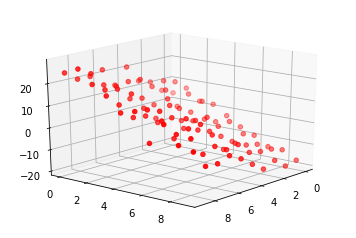

In [3]:
#Generate the grid
x1, x2 = np.meshgrid(range(10), range(10))

#Calculate the z value of the function and then adding some noise
y = 2*x1 - 3*x2 + 8 + np.random.normal(0,3,(10,10))

#Plot the points
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(x1 , x2 , y,  color='red')
ax.view_init(20, 40)

plt.show()

Now that we have the data, we use the algorithm to find the linear fit that minimizes the mean square error. We reshape the data to have the required form for our algorithm. We take the learning rate equal to $0.03$.

In [4]:
X = np.hstack((x1.reshape(-1,1),x2.reshape(-1,1)))
Y = y.reshape(-1,1)
[a,b,c] =  linear_regression(X, Y, 1000, 0.03)

With the parameters we obtained, we plot the corresponding linear surface fitting the data:

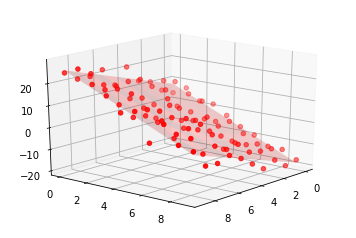

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
z = a + b*x1 + c*x2
ax.plot_surface(x1, x2, z, alpha=0.2, color='red')
ax.scatter(x1 , x2 , y,  color='red')
ax.view_init(20, 40)
plt.show()

It is important to remark that this model is more sensitive to the choice of the learning rate. Let us compare the cost function evaluated at the training data for different choices of the learning rate. First we modify the iterative function so it returns a list of the costs evaluated at the different values of $\theta$ as we iterate.

In [6]:
def linear_regression_cost(X, y, num_steps, learn_rate):
    theta = (2*np.random.rand(X.shape[1]+1)-1).reshape(-1,1)
    cost = []
    for i in range(0,num_steps):
        theta = theta - learn_rate*gradient(X,y,theta)
        if i % 25 == 0:
            cost.append(cost_function(X, y, theta))
    return cost

Now we run the algorithm with the choices of the learning rate $\text{lrn rate}=0.01,0.025,0.04,0.06,0.08$. Disclaimer: the algorithm might throw an exception as it handles very big numbers.

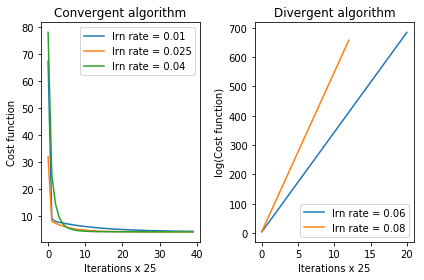

In [7]:
fig1 = plt.subplot(1, 2, 1) #The parameters for subplot are: number of rows, 
                                    #number of columns, and which subplot you're currently on.

plt.plot(range(len(linear_regression_cost(X, Y, 1000, 0.01))),linear_regression_cost(X, Y, 1000, 0.01))
plt.plot(range(len(linear_regression_cost(X, Y, 1000, 0.025))),linear_regression_cost(X, Y, 1000, 0.025))
plt.plot(range(len(linear_regression_cost(X, Y, 1000, 0.04))),linear_regression_cost(X, Y, 1000, 0.04))
plt.title('Convergent algorithm')
plt.xlabel('Iterations x 25')
plt.ylabel('Cost function')
plt.legend(['lrn rate = 0.01', 'lrn rate = 0.025','lrn rate = 0.04'])

fig2 = plt.subplot(1, 2, 2)
plt.plot(range(len(linear_regression_cost(X, Y, 1000, 0.06))),np.log(linear_regression_cost(X, Y, 1000, 0.06)))
plt.plot(range(len(linear_regression_cost(X, Y, 1000, 0.08))),np.log(linear_regression_cost(X, Y, 1000, 0.08)))
plt.title('Divergent algorithm')
plt.xlabel('Iterations x 25')
plt.ylabel('log(Cost function)')
plt.legend(['lrn rate = 0.06', 'lrn rate = 0.08'])

plt.tight_layout()
plt.show()

We can see how with the first three values of the learning rate, the algorithm quickly converges to the optimum. In the second case, the algorithm diverges and the cost function increases exponentially fast. We stress that it is worth spending time and effort trying to optimize the hyperparameters of the algorithm, in this case, the learning rate, as it might change drastically the behavior of our predictors.

## Polynomial regression 

We address now the problem of functions depending on a polynomial way with respect to the features. The main idea is to introduce additional features that capture these non-linear relationships, and then reduce the problem to a multiple linear regression.

## The model

Our data set is now of the form $\{x^{(1)},\dots,x^{(m)} \}$,$\{y^{(1)},\dots,y^{(m)} \}$ where each point $x^{(i)}$ is a vector in $\mathbb{R}^n$  and $y^{(i)}$ is a real number. We want to fit our data to a polynomial model of the form

$$
p(x)=\displaystyle\sum_{|\alpha|\leq d} c_\alpha x^\alpha ,
$$

where $\alpha=(a_1,\dots,a_d)$ is a [multiindex](https://en.wikipedia.org/wiki/Multi-index_notation) of degree $d$. The degree $d$ of the polynomial is a [hyperparameter](https://en.wikipedia.org/wiki/Hyperparameter) of the model. We can reduce the problem to a linear regression problem by creating extra features that capture the non-linear relations between our variables. That is, for each multiindex $\alpha$ of degree larger than $1$, we add the feature $x^\alpha$ to our data set.

### Example:

Suppose our data set consists of points with $3$ features $x_1,x_2,x_3$, and we want to fit a polynomial of degree $3$. Then we will add the extra features of degree $2$, $\{x_1^2,x_2^2,x_3^2,x_1x_2,x_1x_3,x_2x_3\}$ and the features of degree $3$, $\{x_1^3,x_2^3,x_3^3,x_1^2x_2,x_1^2x_3,x_1x_2^2,x_2^2x_3,x_1x_3^2,x_2x_3^2,x_1x_2x_3\}$. $\clubsuit$

Once we have added the extra features, the reduction to linear regression follows from the simple observation that $p(x)$ is simply a linear combination of the new set of variables, and hence, we can apply linear regression to fit the polynomial. 

Let us generate some random data following a cubic trend with normally distributed fluctuations.


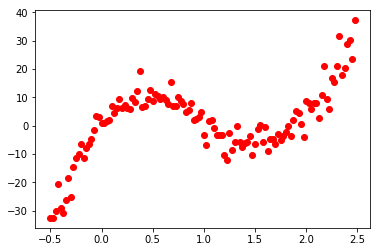

In [8]:
#We generate random data 
X = np.arange(-0.5,2.5,0.025)
y = 20*X*(X-1)*(X-2)+2

#Now we add the random fluctuations
noise = np.random.normal(0,4,120)
y = y + noise

#Now we plot the data
plt.plot(X,y,'ro')
plt.show()

Now we create the polynomial features and stack them into a single matrix M.

In [9]:
M = np.hstack((X.reshape(-1,1),np.hstack(((X**2).reshape(-1,1),(X**3).reshape(-1,1)))))

We can use now the previously constructed multiple linear regression algorithm to fit a polynomial to our data.

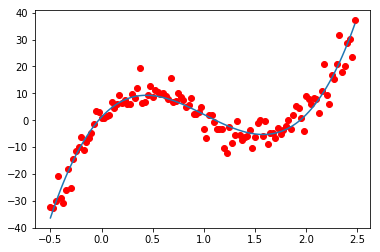

In [10]:
[a,b,c,d]=linear_regression(M, y, 20000, 0.03)
linear_fit =  a+b*X+c*X**2+d*X**3
plt.plot(X,y,'ro')
plt.plot(X,linear_fit)
plt.show()

It is important to remark again that this algorithm is sensitive to the choice of the learning parameter, as it is based on the multiple linear regression. In general, we do not know in advance the degree of the polynomial that fits the best our data, so it is also a hyperparameter of the algorithm. A careful analysis should be done to optimize both the learning parameter and the degree of the polynomial we want to fit. It is also important to keep in mind the variance/bias trade off when optimizing these parameters. We will study this topic in more depth in future notebooks.